In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from stock import *
from sklearn.metrics import mean_absolute_error, mean_squared_error

import mplfinance as mpf

In [2]:
train_loader, test_loader = stock_data_loader("AAPL")

In [3]:
class StockModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=1, output_size=4):
        super(StockModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model = StockModel()

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
n_epochs = 10

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"EPOCH {epoch+1}/{n_epochs}: Loss - {epoch_loss/ len(train_loader):.10f}")

EPOCH 1/20: Loss - 0.0012515864
EPOCH 2/20: Loss - 0.0006636719
EPOCH 3/20: Loss - 0.0006189687
EPOCH 4/20: Loss - 0.0005852169
EPOCH 5/20: Loss - 0.0005655294
EPOCH 6/20: Loss - 0.0005605206
EPOCH 7/20: Loss - 0.0005515004
EPOCH 8/20: Loss - 0.0005463088
EPOCH 9/20: Loss - 0.0005467095
EPOCH 10/20: Loss - 0.0005430990
EPOCH 11/20: Loss - 0.0005453990
EPOCH 12/20: Loss - 0.0005439965
EPOCH 13/20: Loss - 0.0005373049
EPOCH 14/20: Loss - 0.0005397374
EPOCH 15/20: Loss - 0.0005348952
EPOCH 16/20: Loss - 0.0005390890
EPOCH 17/20: Loss - 0.0005349899
EPOCH 18/20: Loss - 0.0005311094
EPOCH 19/20: Loss - 0.0005316857
EPOCH 20/20: Loss - 0.0005319602


In [6]:
model.eval()
all_y_true = []
all_y_pred = []

for inputs, targets in test_loader:
    outputs = model(inputs)
    all_y_pred.extend(outputs.detach().numpy())
    all_y_true.extend(targets.detach().numpy())

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

mae = mean_absolute_error(all_y_true, all_y_pred)
mse = mean_squared_error(all_y_true, all_y_pred)
rmse = np.sqrt(mse)

In [7]:
from stock import load_stock_data
n = 70

X, y = load_stock_data("AAPL")
X_test = X[-n:]
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test.shape

torch.Size([70, 64, 5])

In [8]:
y_test = model(X_test)
y_test = y_test.detach().numpy()
print(y_test[0])
print(y[-n:][0])

[-0.00523932  0.00179072 -0.00924755  0.00217846]
[0.0300145  0.00262118 0.01182225 0.01663322]


In [10]:
raw_data = load_raw_stock_data("AAPL")
raw_data = raw_data[-n - 1:-1]
raw_data.shape

y_pred = np.zeros((n, 4))

for i in range(n):
    for j in range(4):
        y_pred[i][j] = raw_data[i][j] + (y_test[i][j] * raw_data[i][j])

dates = pd.date_range(start="2023-11-10", periods=y_pred.shape[0], freq='D')  # Create date index
df = pd.DataFrame(y_pred, columns=['Open', 'High', 'Low', 'Close'], index=dates)

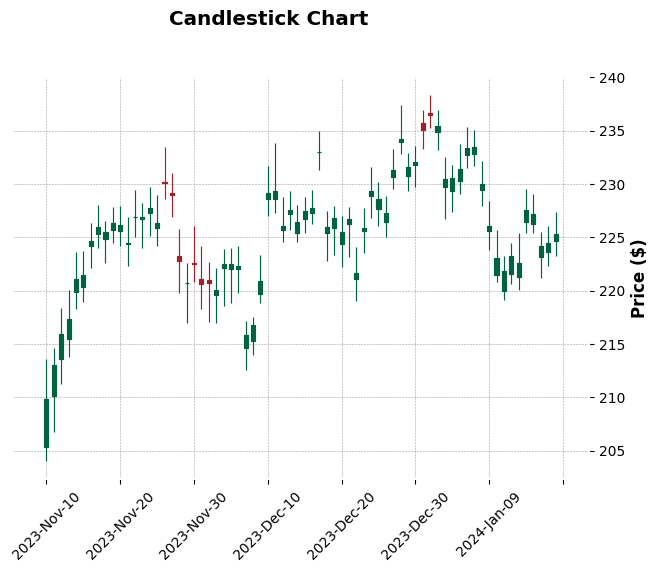

In [14]:
mpf.plot(
    df,
    type='candle',
    style='charles',
    title="Candlestick Chart",
    ylabel="Price ($)",
    # addplot=mpf.make_addplot(ohlc_data['Close'], color='blue', linestyle='--'),
    volume=False
)